In [50]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

In [51]:
# data prep
def gaussian_noise():
    return np.random.normal()


def ar_data_generator(init_seq, weights, noise_func, steps=500):
    """Generate AR(n) simulation data.

    Args:
        init_seq (np.array): Initial values to start with. An AR(n) process should have n initial values.
        weights (np.array): Weights on each prev time step and the noise term.
        noise_func (func): Calling this noise function gives a random term.
        steps (int): Length of the generated sequence.
    """
    init_steps = len(init_seq)
    sim_data = np.zeros(steps + init_steps)
    sim_data[:init_steps] = init_seq
    for i in range(steps):
        cur_val = 0
        for j in range(init_steps):
            cur_val += weights[j] * sim_data[i+j]
        cur_val += weights[-1] * noise_func()
        sim_data[i+init_steps] = cur_val
    return sim_data[init_steps:]


class SeqData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (self.X[idx, :], self.y[idx])


def prepare_ts_ds(data, window_size, target_idx, train_size, val_size, test_size, batch_size):
    """Generate a time series dataset from simulation data.

    Args:
        data (np.array): Possible with F time series data of length N, in the shape of (N, F)
        target_idx (int): The index of the feature to be predicted.
        window_size (int)
        train_size (int)
        val_size (int)
        test_size (int)
    """
    data_len = len(data)
    train_xs, train_ys, test_xs, test_ys = [], [], [], []
    cur_test_num = 0
    for i in range(data_len):
        if i >= window_size:
            if i < (train_size + val_size) * 1.5:
                train_xs.append(data[i-window_size:i, :])
                train_ys.append(data[i, target_idx])
            elif cur_test_num < test_size:
                cur_test_num += 1
                test_xs.append(data[i-window_size:i, :])
                test_ys.append(data[i, target_idx])
            else:
                break
    train_xs = np.array(train_xs)
    train_ys = np.array(train_ys)
    test_xs = np.array(test_xs)
    test_ys = np.array(test_ys)
    dataset = SeqData(X=train_xs, y=train_ys)
    test_dataset = SeqData(X=test_xs, y=test_ys)
    train_dataset, val_dataset, _ = torch.utils.data.random_split(dataset, [train_size, val_size, len(dataset)-train_size-val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size ,shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

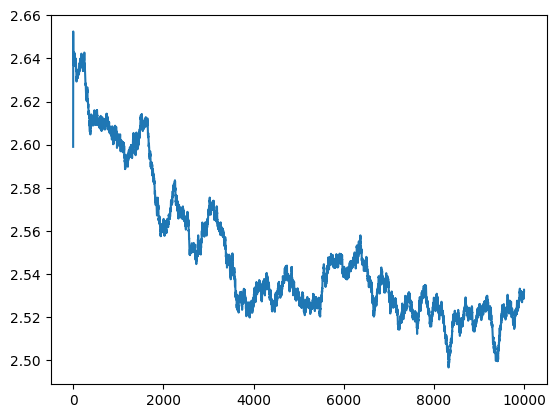

In [58]:
# simulation data
init_seq = np.array([1, 2, 3])
weights = np.array([0.1, 0.2, 0.7, 0.01])
noise_func = gaussian_noise
steps = 10000
sim_data = ar_data_generator(init_seq, weights, noise_func, steps)
data = sim_data[:, None]
# plt.plot(sim_data)
# plt.show()

# dataloader
train_dl, val_dl, test_dl = prepare_ts_ds(data, 3, 0, 2000, 500, 1000, 32)

In [53]:
# models
class FF(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim):
        super(FF, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.fc2 = nn.Linear(seq_length, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # (batch size x seq length x input dim)
        x = self.relu(self.fc1(x))[:, :, 0]
        # (batch size x seq length)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [54]:
model = FF(1, 3, 16)
